In [1]:
# switch to main dir to fix local imports
import os
if os.getcwd().endswith("notebooks"):
    os.chdir("..")

# package imports
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from  matplotlib.ticker import PercentFormatter
import torch
from tqdm.notebook import tqdm
from dataclasses import asdict
import networkx as nx
import glob

# local imports
from src.args import Args
import src.graphs as graphs
import src.subgraphs as subgraphs

# start autoreload
%load_ext autoreload
%autoreload 2

# select device for machine learning
device = "cuda" if torch.cuda.is_available() else ("mps" if torch.backends.mps.is_available() else "cpu")
print(f"using device: {device}")

# settings for plots (seaborn/matplotlib)
sns.set_context("paper")
sns.set_style("darkgrid", {"grid.color": ".8"})
palette = "Dark2"

using device: cuda


### Load dataframe

In [ ]:
result = pd.concat((pd.read_csv(f) for f in glob.glob("/out/load/*.csv.zip")), ignore_index=True)

# Class imbalance

This experiment visualizes the inherit class imbalance of sparse graphs, here an RGG.

In [ ]:
graph = graphs.gen_rgg(1000, 10)
n_nodes = len(graph.nodes(data=False))
n_edges = len(graph.edges(data=False))

fig_size = 4
fig, ax = plt.subplots(
    figsize=(fig_size, fig_size),
)

ax.pie(
    [ n_edges, (n_nodes * (n_nodes - 1) / 2) - n_edges ],
    labels=["Edge", "Non Edge"],
    colors=sns.color_palette(palette)[0:2],
    startangle=90,
    autopct=None,
)

fig.subplots_adjust(top=1, bottom=0, right=1, left=0, hspace=0, wspace=0)
ax.axis('equal')
ax.margins(0, 0)

plt.tight_layout(pad=0)
plt.savefig("./out/class_imbalance_pie_1000.pdf")

# Class imbalance - subsampling

This experiment visualizes how the class imbalance behaves for different graph sizes (of sparse graphs) with and without rjs-subsampling.

In [2]:
args_list = [
    Args(
        graph_type="rgg",
        graph_size=graph_size,
        subgraph_alg=subgraph_alg,
        # rgg specific settings
        rgg_avg_degree=10
    )
    for graph_size in [500, 1000, 2000, 3000, 4000, 5000]
    for subgraph_alg in ["rjs", "none"]
    for _ in range(100)
]

In [3]:
# generate data
result = pd.DataFrame({})
for r, args in enumerate(tqdm(args_list)):
    # generate graph and subgraph
    graph = graphs.gen_graph(args)
    subgraph = subgraphs.sub_of(
        alg=args.subgraph_alg,
        graph=graph,
        size=args.subgraph_size,
        alpha=args.subgraph_alpha
    )
    # save class imbalance
    n = nx.number_of_nodes(subgraph)
    e = nx.number_of_edges(subgraph)
    result = pd.concat([
        result,
        pd.Series({
            "run_index": r,
            "n_nodes": n,
            "n_edges": e,
            "edge_imbalance": 2 * e / (n * (n - 1)),
            **asdict(args),
        }).to_frame().T
    ], ignore_index=True)

result.to_csv(f"./out/class_imbalance.csv.zip", index=False, compression=dict(method='zip', archive_name=f"data.csv"))

  0%|          | 0/1200 [00:00<?, ?it/s]

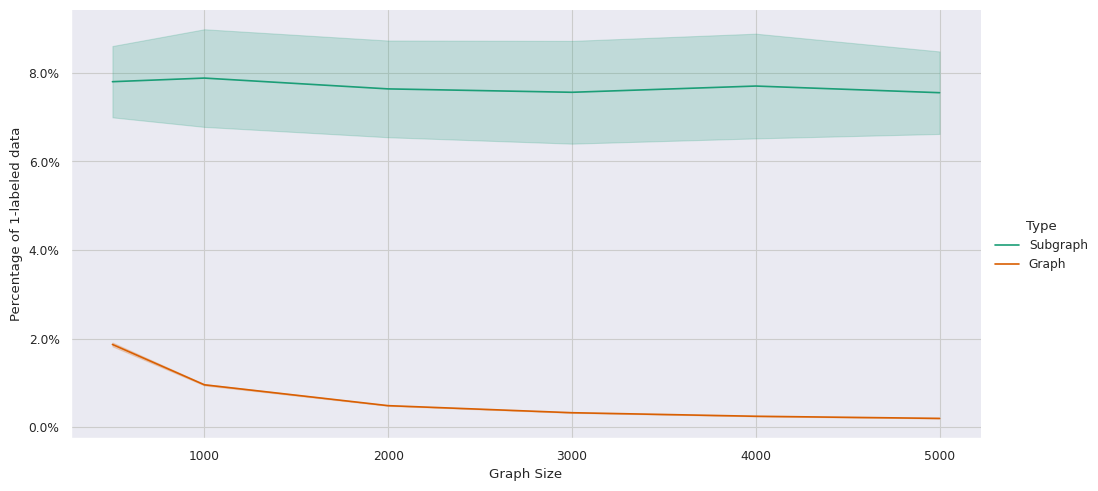

In [4]:
g = sns.relplot(
    kind="line",
    data=result.assign(Type=result["subgraph_alg"].map({"none": "Graph", "rjs": "Subgraph"})),
    x="graph_size",
    y="edge_imbalance",
    hue="Type",
    errorbar="sd",
    aspect=2,
    palette=palette,
)
g.set_axis_labels("Graph Size", "Percentage of 1-labeled data")
g.ax.yaxis.set_major_formatter(PercentFormatter(1))

g.fig.savefig('./out/class_imbalance.pdf')